In [228]:
import warnings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>") )
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import glob
import os
import itertools as it
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
import seaborn as sns
from scipy import stats
from sklearn import calibration


from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import datetime as dt

def load_predictions_gen(_path_pred):
    
    
    if os.path.isdir(_path_pred):
        li_pred_fns = list( glob.glob(_path_pred+"/*", recursive=False) )
        li_pred_fns = [pred_fns for pred_fns in li_pred_fns if pred_fns[-4:]==".dat" ]
        
    elif os.path.isfile(_path_pred):
        li_pred_fns = [ _path_pred ]
    
    else:
        raise ValueError("Invalid File passed")
            
    li_pred_fns.sort()
    for pred_fn in li_pred_fns:
        pred = pickle.load(open(pred_fn,"rb"))
        yield pred
        
dict_prediction_path = {}

## Model Evaluation Code

In [269]:
def model_evaluation(datformation, rain_threshold=0.5, rolling_anual=False):
    
    prediction_path, distr_name, mname = init_helper(datformation)


    #timestamps, truevalues, preds = get_data(prediction_path)
    li_pred_fns = list( glob.glob(prediction_path+"/*",recursive=False) )

    li_pred_fns = [pred_fns for pred_fns in li_pred_fns if pred_fns[-4:]==".dat" ]
    li_pred_fns.sort()
    li_ts_tv_ps = get_data(prediction_path, multiple_files=stochastic)

    for idx, (timestamps, truevalues, preds) in enumerate(li_ts_tv_ps):

        fd = prediction_path.rsplit('/',2)[0]

        if os.path.isdir(prediction_path):
            _dir = prediction_path
        else:
            _dir = os.path.dirname(prediction_path)

        os.path.makedirs(_dir+"/Evaluation",exist_ok=True)

        preds_mean = np.mean(preds,axis=-1)

        rmse = rmse_aggregate(preds_mean, truevalues)
        bias = bias_aggregate(preds_mean, truevalues)
        rN_rmse, N = rN_aggregate(preds_mean, truevalues)

        avg_pred_rain = np.nanmean(preds_mean)
        avg_true_rain = np.nanmean(truevalues)

        dict_data = {'RMSE':[rmse], 'Bias':[bias] ,"R{}_RMSE".format(str(N)):[rN_rmse], 'Avg Pred':avg_pred_rain }
        _dataframe = pd.DataFrame(dict_data )

        _dataframe.to_csv( _dir+"/Evaluation/general_scores.csv" ,index=False)
        
        image_all_preds(timestamps, truevalues, preds_mean, _dir, figsize=(8,6)) #RODO: Convert images to make an image every say 90 days


        # Collecting an annually aggreagted set of results
        if rolling_anual==True:
            #Performing test on annual chunks and save results into one txt file

            _dataframe_1yre = year_rolling_eval( preds, preds_mean, li_preds_p ,truevalues, timestamps, rain_threshold, distr_name, fd )

            #Save to csv file
            _dataframe_1yre.to_csv( fd+"/scores_1yrs_"+fn+".csv" ,index=False)

            #Super-Imposing RMSE,r10_RMSE, AUC
            x = _dataframe_1yre['Start_Year']
            Y1 = _dataframe_1yre['RMSE']
            Y2 = _dataframe_1yre['R10_RMSE']
            Y3 = _dataframe_1yre['AUC_Score']

            color = sns.color_palette("dark", 2)
            with sns.axes_style("whitegrid"):
                fig, ax1 = plt.subplots( )#, figsize=(30,7))

                #color = ['blue','green']

                ax1.set_xlabel('Year')
                ax1.set_ylabel('RMSE', color=color[0])
                a= ax1.plot(x,Y1,color=color[0], marker='x', label='RMSE', lw=1.6 )
                b = ax1.plot(x, Y2, color=color[0], linestyle='--', marker='x', label='R10 RMSE',lw=1.6)
                ax1.tick_params(axis='y', labelcolor=color[0])


                ax2 =ax1.twinx()
                ax2.set_ylabel('AUC', color=color[1])
                c = ax2.plot(x, Y3, color=color[1],lw=1.6)
                ax2.tick_params(axis='y', labelcolor=color[1])

                ax1.legend(loc="upper left", bbox_to_anchor=(0,1) , bbox_transform=ax1.transAxes)
                #ax2.legend(loc="upper right", bbox_to_anchor=(1,0) , bbox_transform=ax2.transAxes)

                nticks = 8
                ax1.yaxis.set_major_locator(plticker.LinearLocator(nticks))
                ax2.yaxis.set_major_locator(plticker.LinearLocator(nticks))
                ax1.yaxis.set_major_formatter(plticker.FormatStrFormatter('%.2f'))
                ax2.yaxis.set_major_formatter(plticker.FormatStrFormatter('%.3f'))
                p = [a[0],b[0],c[0]]
                ax1.legend(p, [p_.get_label() for p_ in p], loc= 'upper center', fontsize= 'small')


                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                fig.show()

            img_dir = fd + "/Images"
            fn_name = fn+"running_aucrmse.png"
            if not os.path.exists(img_dir):
                os.makedirs(img_dir)

            plt.savefig(img_dir+"/"+fn_name )



        print("Completed {} \n".format(fn) )
        
        return dict_data
            
def init_helper(datformation):
    
    if isinstance(datformation, dict):
        prediction_path = datformation['fp']
        distr_name = datformation['distr_name']
        model_name = datformation.get('model_name','')
    else:
        prediction_path = datformation
        distr_name =None
        
    return prediction_path, distr_name, model_name
    
def get_data(prediction_path, multiple_files=False):
    #return timestamps, truevalues, preds
    
    li_data = list(load_predictions_gen(prediction_path))
    
    li_ts_tv_ps = []
    
    for data in li_data:
        
        if 1 in data[1][0].shape and type(data[1][0]) != np.float64:    
            preds = np.concatenate(data[1][0])
            preds = np.reshape(data[1],[-1])
            preds = np.expand_dims(preds, [-1])
            
        
        elif type(data[1][0]) != np.float64 and type(data[1])==list:
            preds = np.concatenate( data[1],axis=0) 
            truevalues = np.concatenate( data[2],axis=0)
            timestamps = np.concatenate(data[0])
            
            
        elif len(data[1].shape) == len(data[2].shape):
            preds = np.expand_dims(data[1],axis=-1)
            truevalues = data[2]
            timestamps = data[0]
            
        else:
            
            preds = np.expand_dims(data[1],axis=1)
            truevalues = data[2]
            timestamps = data[0]
        
        li_ts_tv_ps.append( (timestamps, truevalues, preds) )
        
    if multiple_files == False:
        return li_ts_tv_ps[0]
    else:
        return li_ts_tv_ps
        
def percentile_cal(confidence, preds, distr_name):
    mean, sigma = np.mean(preds,axis=1), np.std(preds,ddof=1,axis=1)
#     print(mean)
#     print(sigma)

    if distr_name == "Normal":
        lp,up =  stats.norm.interval( confidence, loc=mean, scale=sigma)
        lp = np.where(lp>=0,lp, 0.0)

    elif distr_name == "LogNormal":
        ln_lp,ln_up = stats.lognorm.interval( confidence, scale=mean, s=underlying_normal_std_from_lnnormal_std(mean,sigma))
        ln_lp = np.where(ln_lp>=0,ln_lp, 0.0)
        
        n_lp,n_up =  stats.norm.interval( confidence, loc=mean, scale=sigma)
        n_lp = np.where(n_lp>=0,n_lp, 0.0)
        
        
        lp = np.where( mean>0.5,  ln_lp, n_lp )
        up = np.where( mean>0.5 , ln_up, n_up)
        
    else:
        raise ValueError
    
    return lp, up

def underlying_normal_std_from_lnnormal_std(ln_mean, ln_std):
    _1 = np.log( np.square(ln_std) + np.square(ln_mean) )
    _2 = -2 * np.log(ln_mean)
    sigma_norm = np.sqrt(_1 + _2)
    return sigma_norm
       
def rmse_aggregate(preds_mean,true_vals):
    return np.sqrt(np.nanmean((preds_mean-true_vals)**2))

def bias_aggregate(preds_mean, true_vals):
    return np.nanmean( preds_mean-true_vals )

def rN_aggregate(preds_mean, true_vals, N=10):
    
    mask = true_vals >= N
    
    preds_filt = preds_mean[mask]
    true_vals_filtr = true_vals[mask]
    
    return np.sqrt(np.nanmean((preds_filt-true_vals_filtr)**2)), N   

def avg_abs_bias(preds_mean ,true_vals):
    diff = preds_mean-true_vals
    abs_diff = np.abs(diff)
    avg_abs_bias = np.nanmean(abs_diff)
    return avg_abs_bias

def image_all_preds(tss, true_val, pred_mean, prediction_dir,figsize=(10,8)):
    ts = [ d.strftime("%d-%m-%y", time.localtime(int(d))) for d in tss]
    
    start = pd.to_datetime( ts[0] )
    end = pd.to_datetime(  ts[-1] ) + pd.Timedelta(1, 'd')
    
    ts = mdates.drange(start,end,dt.timedelta(days=1))
    
    fig, (ax) = plt.subplots(1,figsize=(10,8))
    ax.plot(ts, true_val,color='black',linewidth=1)
    ax.plot(ts, pred_mean.reshape([-1]), color='blue')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20) )
   
    fig.show()
    
    img_dir = prediction_dir + "/Images"
    fn_name = "all_predictions.png"
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
        
    plt.savefig(img_dir+"/"+fn_name )
      
def image_all_preds_stochastic(tss, true_val, pred_mean, li_pred_uncertainty_bands, prediction_path, fd, fn, save=True, figsize=(10,6) ):
    
    tss_string = [ time.strftime("%d-%m-%y", time.localtime(int(_val))) for _val in tss]
    
    start = pd.to_datetime( tss_string[0] )
    end = pd.to_datetime( tss_string[-1] ) + pd.Timedelta(1, 'd')
    
    ts = mdates.drange(start,end,dt.timedelta(days=1))
    
    fig, (ax) = plt.subplots(1,figsize=figsize )
    clrs = ['blue']# sns.color_palette("husl", 1)
    
    with sns.axes_style("darkgrid"):        
        ax.plot(ts[:len(true_val)], true_val, c='black',linewidth=0.8)
        ax.plot(ts[:len(true_val)], pred_mean, c=clrs[0],linewidth=0.7)
        ax.fill_between(ts[:len(true_val)], li_pred_uncertainty_bands[0], li_pred_uncertainty_bands[1] ,alpha=0.1, facecolor=clrs[0])
        ax.plot(ts[:len(true_val)], li_pred_uncertainty_bands[1], alpha=1, c=clrs[0], linestyle=(0, (1, 1)),linewidth=0.25 )
        #ax.legend()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20) )
    
    fig.show()
    if save==True:
        img_dir = fd + "/Images"
        fn_name = "all_preds_"+fn+".png"
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)

        plt.savefig(img_dir+"/"+fn_name )
        
def image_all_preds_compare(li_tss, li_true_vals, li_preds, li_confidence=[None,None], li_distr=[None,None], names=['Model1','Model2'], figsize=(10,6)):
    ts_strings = [ time.strftime("%d-%m-%y", time.localtime(int(_val))) for _val in li_tss[0] ]
    ts1_strings = [ time.strftime("%d-%m-%y", time.localtime(int(_val))) for _val in li_tss[1] ]
    
    try:
        start = pd.to_datetime( ts_strings[0] )
        end = pd.to_datetime( ts_strings[-1] ) + pd.Timedelta(1, 'd')

        start1 = pd.to_datetime( ts1_strings[0] )
        end1 = pd.to_datetime( ts1_strings[-1] ) + pd.Timedelta(1, 'd')
    
        ts = mdates.drange(start,end,dt.timedelta(days=1))
        ts1 = mdates.drange(start1,end1,dt.timedelta(days=1))
    except (ValueError,IndexError) as e:
        return
    
    li_ts = [ts,ts1]
    size=18
    fig, (ax) = plt.subplots(1,figsize=figsize)   
    #clrs = sns.color_palette("husl", 2)
    clrs = [ 'darkblue','darkorange' ]
    with sns.axes_style("whitegrid"):
    
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
        
        ax.xaxis.set_major_locator(mdates.AutoDateLocator() )
        #ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO) )
        
        if names[0] == names[1]:
            _range = 1
        else:
            _range = 2
        for idx in range(_range):
            _mean = np.mean(li_preds[idx],-1)
            
            _len = min( len(li_true_vals[idx]), len(li_ts[idx])  )

            if idx == 0:
                ax.plot(li_ts[idx][:_len], li_true_vals[idx][:_len], c='grey',linewidth=6, label="True Rain", alpha=0.5)
            
            ax.plot(li_ts[idx][:_len], _mean[:_len], c=clrs[idx], label=names[idx], linestyle=':' , linewidth=4.0)

            if li_distr[idx] != None:
                lq, uq = percentile_cal(li_confidence[idx], li_preds[idx], li_distr[idx] )
                ax.fill_between(li_ts[idx][:_len], lq[:_len], uq[:_len] ,alpha=0.2, facecolor=clrs[idx])
                ax.plot(li_ts[idx][:_len], uq[:_len], alpha=0.7, c=clrs[idx], linestyle=':' )
    
    ax.tick_params(axis='x', labelsize=size)
    ax.tick_params(axis='y', labelsize=size)
    ax.set_xlabel('Date', fontsize=size)
    ax.set_ylabel('rain (mm)', fontsize=size, rotation='horizontal')
    ax.yaxis.set_label_coords(0.04,1.02) 
    
    #plt.legend(loc=(0.625,0.6),fontsize=size-1,framealpha=0.6)
    plt.legend(loc='upper_right',fontsize=size-1,framealpha=0.6)
    
    ax.grid(True)
    fig.show()
    #ax.set_title("Comparison of {} and {}".format(names[0], names[1]) )
    
#-- UQ --
def year_rolling_eval(preds, preds_mean, li_preds_p ,true_values, timestamps, rain_threshold, distr_name, prediction_path):
    
    #Divide data into two year contiguous chunks
    #start_date = np.datetime64('1987-12-31')   #1987-11-01
    start_date = np.datetime64(int(timestamps[0]),'s')
    end_date = np.datetime64(int(timestamps[-1]),'s')
    
    time_intrvls_years = pd.date_range( end=end_date, start=start_date, freq='1Y',normalize=True)
    time_intrvls_epochs = list ( (time_intrvls_years - pd.Timestamp("1970-01-01") ) // pd.Timedelta('1s') ) #holds the start time for every 2 year interval
    
    start_idxs_for_intrvls = np.searchsorted(timestamps, np.array(time_intrvls_epochs) )
       
    li_startend_date = []
    li_rmse = []
    li_r10_rmse = []
    li_AUC = []
    
    for idx_year, (idx_start, idx_end) in enumerate( zip(start_idxs_for_intrvls, start_idxs_for_intrvls[1:])) :
        
        rmse = rmse_aggregate(preds_mean[idx_start: idx_end], true_values[idx_start:idx_end])
        
        r10_rmse, _, N = rN_aggregate_stochastic(preds_mean[idx_start: idx_end], li_preds_p[1][idx_start: idx_end], true_values[idx_start: idx_end] )
        
        auc = uncertainty_quantification_sherman( preds[idx_start: idx_end], true_values[idx_start: idx_end], rain_threshold, distr_name ,make_plot=False)
        startend = ( time_intrvls_years[idx_year].strftime("%Y-%m-%d"), time_intrvls_years[idx_year+1].strftime("%Y-%m-%d")  )
        
        
#         image_all_preds_stochastic( timestamps[idx_start: idx_end] , 
#                                    true_values[idx_start: idx_end], 
#                                        preds_mean[idx_start: idx_end], 
#                                    [li_preds_p[0][idx_start: idx_end], li_preds_p[1][idx_start: idx_end]], prediction_path, fd="", fn="", save = False)
            
        li_rmse.append(rmse)
        li_r10_rmse.append(r10_rmse)
        li_AUC.append(auc)
        li_startend_date.append( (' - ').join(startend) )
    
    _dataframe = pd.DataFrame({'Start_Year':time_intrvls_years[:len(li_startend_date)] ,'RMSE':li_rmse, "R10_RMSE":li_r10_rmse, "AUC_Score":li_AUC, "Start-End":li_startend_date } )
    
    return _dataframe

pd_timestamps = None
# --  Summary Stats for Seasons
def summary_stat_seasonal(datformation,city="", method="generic"):
    
    # Retrive predictions, true_values and dates
    
    prediction_path, distr_name, mname = init_helper(datformation)
    
    timestamps, truevalues, preds = get_data(prediction_path)
    
    #print(preds.shape)
    preds_mean = np.nanmean(preds,axis=-1)
    
    #print(f"Are any values nan {np.any(np.isnan(preds_mean))}\n")
    
    # Finding indexes to divide data into seasons
    pd_timestamps = pd.DatetimeIndex(np.array(timestamps).astype('datetime64[s]') )
    
    #print(pd_timestamps.shape)
        
    seasons = ['Winter','Spring','Summer','Autumn']
    arr_seasons, bins = pd.cut( pd_timestamps.month % 12,
                                   [0,3,6,9,12],labels=seasons, right=False,
                                      include_lowest=True, retbins=True)
    
    # Adding summary statistics
    dict_s_boolindc = {}
    df_season_summary = pd.DataFrame(columns=['RMSE','R10 RMSE','MAE', 'Avg Bias']) #,'Avg Pred', 'Avg Obs' ])
    
    for idx, season in enumerate(seasons):
        
        bool_indc = (arr_seasons == season)

        season_preds_mean = preds_mean[bool_indc]
        season_obs = truevalues[bool_indc]
                
        rmse = rmse_aggregate(season_preds_mean,season_obs)
        r10rmse, _ = rN_aggregate(season_preds_mean,season_obs,10)
        mae = avg_abs_bias(season_preds_mean, season_obs)
        avg_pred_rain = np.nanmean(season_preds_mean)
        avg_true_rain = np.nanmean(season_obs)
        

        df_season_summary = df_season_summary.append( pd.Series( { 'RMSE':rmse ,'R10 RMSE':r10rmse,'MAE':mae, 'Avg Bias': avg_pred_rain - avg_true_rain } ).rename(season) )
        
        
        
    #adding aggregated results
    rmse = rmse_aggregate(preds_mean,truevalues)
    r10rmse, _ = rN_aggregate(preds_mean,truevalues,10)
    mae = avg_abs_bias(preds_mean,truevalues)
    avg_pred_rain = np.nanmean(preds_mean)
    avg_true_rain = np.nanmean(truevalues)
    
    series = pd.Series( { 'RMSE':rmse ,'R10 RMSE':r10rmse,'MAE':mae, 'Avg Bias':avg_pred_rain-avg_true_rain } )
    df_season_summary = df_season_summary.append( series.rename("All") )
    
    if method=="experiment1":
        return df_season_summary
    
    print(df_season_summary)
    
    if os.path.isdir(prediction_path):
        _buf = prediction_path+f"/seasonal_summary_stats{city}.tex"
    else:
        _dir = os.path.dirname(prediction_path)
        _buf = _dir+f"/seasonal_summary_stats{city}.tex"

    df_season_summary.to_latex( buf=_buf,  float_format="{:0.3f}".format, caption=f"Seasonally aggregated Performance Metrics for {mname} trained on data \
                               between 1979 and 2013 and tested on the $7.1 {{\\times}} 10^3$ $\mathrm{{km}}^2$ region around \\textbf{{{city}}} between 2014 and 2019-07".replace("_","\-"))

#correlation--------

def auto_correllation_plots(datformation, city, errors=False):
    
    prediction_path, stochastic, distr_name, mname = init_helper(datformation)
    
    timestamps, truevalues, preds = get_data(prediction_path)
    
    #TODO: fix naming scheme for this series
    preds_mean = np.mean(preds,axis=-1)
    
    if errors==True:
        preds_mean = truevalues[:len(preds_mean)] - preds_mean
    
    preds_mean = mlab.detrend(preds_mean, key='linear')
    # Finding indexes to divide data into seasons
    
    
    pd_timestamps = pd.DatetimeIndex(np.array(timestamps).astype('datetime64[s]') )
    
    fig, ax1 = plt.subplots(1,1 )
    maxl = 94
    ax1.acorr(preds_mean,usevlines=True, maxlags=maxl, normed=True, lw=2)
    ax1.axhline(y=0.05, color='r', linestyle='--',label='y=0.05')
    
    ax1.set_xlim([1,maxl])
    ax1.set_ylim([-0.1,0.40])
    ax1.set_xlabel('Lags')
    ax1.set_title(f"{city}")
    
    ax1.legend()
    ax1.grid(True)
    
    
    if os.path.isdir(prediction_path):
        _buf = prediction_path+"/acf_{city}"
    else:
        _dir = os.path.dirname(prediction_path)
        _buf = _dir+f"/acf_{city}"
    
    if errors:
        _buf += "_errors.png"
    else:
        _buf += "_preds.png"
        
    plt.savefig(_buf)
    plt.show()

def cross_correllation_plots(li_datformation, cities, errors=False):
    
    """ Pass in 2 cities, 1st city is base city"""
    
    li_info = [ init_helper(datformation) for datformation in li_datformation ] #prediction_path, stochastic, distr_name, mname = init_helper(datformation)
    
    li_ts_tv_ps = [ get_data(info[0]) for info in li_info ] #(timestamps, truevalues, preds)
    
    li_city_preds = [ (city,np.mean(ts_tv_ps[2],axis=-1) ) for city,ts_tv_ps in zip(cities,li_ts_tv_ps)  ]
    
    li_city_truevs = [ (city, ts_tv_ps[1] ) for city,ts_tv_ps in zip(cities,li_ts_tv_ps)  ]
    
    
    fig, ax1 = plt.subplots(1,1)
    #fig.canvas.set_title('Cross Correlations')
    
    maxl = 28
    if errors:
        x1 = li_ts_tv_ps[0][1] - li_city_preds[0][1]
        x2 = li_ts_tv_ps[1][1] - li_city_preds[1][1]
    else:
        #TRU-NET city 1 and city 2 preds
        x1 = li_city_preds[0][1]
        x2 = li_city_preds[1][1]

        #Observed values city 1 and city 2 preds
        x3 = li_city_truevs[0][1]
        x4 = li_city_truevs[1][1]

    ax1.xcorr( x1, x2, maxlags=maxl, normed=True ,lw=2, usevlines=False, linestyle='--', detrend=mlab.detrend_linear, label="TRUNET-CC", color='blue' )
    
    ax1.xcorr( x3, x4, maxlags=maxl, normed=True ,lw=2, usevlines=False, linestyle='--' ,detrend=mlab.detrend_linear, label="Observed", color='orange' )

    ax1.axhline(y=0.05, color='r', linestyle='-.', label='y=0.05')
    
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim([-0.1,maxl])
    ax1.set_ylim([-0.1,1])
    ax1.set_xlabel('Lags')
    ax1.set_title(f'XCF: {li_city_preds[0][0]}-{li_city_preds[1][0]}')
    
    prediction_path = li_info[0][0]
    if os.path.isdir(prediction_path):
        _buf = prediction_path+"/xcf_{city}"
    else:
        _dir = os.path.dirname(prediction_path)
        _buf = _dir+f"/xcf_{cities[0]}_{cities[1]}"
    
    if errors:
        _buf += "_errors.png"
    else:
        _buf += "_preds.png"
        
    plt.savefig(_buf)
    plt.close()
    
        
    return np.corrcoef([x1,x2])[0,1], np.corrcoef([x3,x4])[0,1]

def decade_by_decade_eval(datformation,city):
    
    # Retrive predictions, true_values and dates
    
    prediction_path, stochastic, distr_name, mname = init_helper(datformation)
    
    timestamps, truevalues, preds = get_data(prediction_path)
    preds_mean = np.mean(preds,axis=-1)
    
    # Finding indexes to divide data into decades
    
    
    pd_timestamps = pd.DatetimeIndex(np.array(timestamps).astype('datetime64[s]') )
    
    #print(pd_timestamps)
    
    decades = ["2000s","2010s"]
    
    arr_decades, bins = pd.cut( pd_timestamps.year,
                                   [1999,2010,2020],labels=decades, right=False,
                                      include_lowest=True, retbins=True)
    
    # Adding summary statistics
    dict_s_boolindc = {}
    df_decade_summary = pd.DataFrame(columns=['RMSE','R10RMSE','Avg Abs Bias', 'Avg Pred', 'Avg Obs' ])

    for idx, decade in enumerate(decades):
        bool_indc = (arr_decades == decade)
                
        decades_preds_mean = preds_mean[bool_indc]
        decades_obs = truevalues[bool_indc]
                
        rmse = rmse_aggregate(decades_preds_mean,decades_obs)
        r10rmse, _ = rN_aggregate(decades_preds_mean,decades_obs,10)
        avgabsbias = avg_abs_bias(decades_preds_mean, decades_obs)
        avg_pred_rain = np.mean(decades_preds_mean)
        avg_true_rain = np.mean(decades_obs)
        
        df_decade_summary = df_decade_summary.append( pd.Series( { 'RMSE':rmse ,'R10RMSE':r10rmse,'Avg Abs Bias':avgabsbias, 'Avg Pred':avg_pred_rain, 'Avg Obs':avg_true_rain } ).rename(decade) )
    
    df_decade_summary.index.name = "Decade"
    print(df_decade_summary)
    
    if os.path.isdir(prediction_path):
        _buf = prediction_path+f"/decade_summary_stats{city}.tex"
    else:
        _dir = os.path.dirname(prediction_path)
        _buf = _dir+f"/decade_summary_stats{city}.tex"

    df_decade_summary.to_latex( buf=_buf,  float_format="{:0.3f}".format, caption=f"Decade aggregated Performance Metrics for {mname} trained on data \
                               between 1979 and 1999 and tested on the $7.1 {{\\times}} 10^3$ $\mathrm{{km}}^2$ region around \\textbf{{{city}}} between 2000 and 2019-07".replace("_","\-"))

def scatter_plot(datformation, threshold=0.5):
    """Produces x-y and logx-logy scatter plot of predictions against Observed values """
    
    prediction_path, distr_name, mname = init_helper(datformation)
    
    timestamps, truevalues, preds = get_data(prediction_path)
    preds_mean = np.mean(preds,axis=-1)
    
    #Removing values where observed value is zero
    bool_mask = truevalues>=threshold
    preds_mean = preds_mean[bool_mask][::100]
    truevalues = truevalues[bool_mask][::100]
    
    
#     #normal plot 
#     fig, ax1 = plt.subplots(1,1 )
#     ax1.scatter( truevalues, preds_mean, marker='x', alpha=0.1 )
    
#     xpoints = ypoints = ax1.get_xlim()
#     ax1.plot(xpoints, ypoints, linestyle='--', color='r', lw=1.5, scalex=False, scaley=False, label="y=x" )

#     ax1.set_title("Observed rainfall against Predicted Rainfall")
#     ax1.set_xlabel('Observed rainfall mm/day')
#     ax1.set_ylabel('Predicted rainfall mm/day')
#     ax1.legend()
#     ax1.grid(True)
#     ax1.set_ylim(  ax1.get_xlim() )
    
#     _dir = "./Output/Experiment1/figures"
#     if os.path.isdir(_dir) == False:
#         os.mkdir(_dir)
        
#     plt.savefig(_dir+f"/scatter_obs_preds_{mname}_thold_{str(threshold)}.png")
#     plt.show()
    
    #log-log plot
    #normal plot 
    fig, ax1 = plt.subplots(1,1 )
    ax1.scatter( np.log(truevalues+1), np.log(preds_mean+1), marker='x', alpha=0.05 )
    xpoints = ypoints = ax1.get_xlim()
    ax1.plot(xpoints, ypoints, linestyle='--', color='r', lw=1.5, scalex=False, scaley=False, label="y=x" )
    
    ax1.set_title("Log Observed rainfall against Log Predicted Rainfall")
    ax1.set_xlabel('Log Observed rainfall mm/day')
    ax1.set_ylabel('Log Predicted rainfall mm/day')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(  ax1.get_xlim() )
    
    _dir = "./Output/Experiment1/figures"
    if os.path.isdir(_dir) == False:
        os.mkdir(_dir)
        
    plt.savefig(_dir+f"/scatter_log_obs_preds_{mname}_thold_{str(threshold)}.png")
    plt.show()

# Multi-Model: Generic Evaluation w/ Seasonal Breakdown 

In [156]:
model_names = ["HGCRU","HGCRU+CC","T-NET","T-NET+CC", "IFS" ]
models_path_name = ["SimpleConvGRU_mc_dropout_Normal_False", "SimpleConvGRU_mc_dropout_Normal_True", "TRUNET_mc_dropout_Normal_False","TRUNET_mc_dropout_Normal_True","ERA5/preds"]
locs_train = ["Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban"]*4 + [""]
locs_test = ["All"]*5

_dir = "./Output/Experiment1/tables"
os.makedirs(_dir, exist_ok=True)

#general scores and year by year break down

li_df_season_summary = []

for mn, mpn, loc_train, loc_test in zip(model_names, models_path_name, locs_train, locs_test):
    
    if mn=="IFS":
        fp = f"Output/ERA5/preds/{loc_test}_2014_2019-06-11_pred.dat"
    else:
        fp = f"Output/{mpn}_{loc_train}_{loc_test}_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional.dat"
        
    info_dict = {"fp": fp, "stochastic":False, 'distr_name':None, "model_name":mpn}
    #print(fp)
    
    df_season_summary = summary_stat_seasonal(info_dict, method="experiment1" ) #RMSE, R10RMSE, Avg. Bias, avg Pred, avg. Observerd per season. dict for each model, with a row for each season
    #print(df_season_summary)
    #Create pandas dataframe with multi-idnex, index=(model_name,season)
    
    li_df_season_summary.append( df_season_summary )
    
#Now cretae multi indexed data    
# df_seasons = pd.DataFrame(li_scores_seasons)
df_combined = pd.concat(li_df_season_summary, keys=model_names, axis=0)#.reset_index(level=1)
df_combined = df_combined.rename_axis(["Model name", "season"])[['RMSE','R10 RMSE','MAE']]

# Printing seperate tables for each Season
for season in df_combined.index.levels[1]:
    df_season = df_combined.xs((season), level=(1))
    print(season)
    print(df_season)
    print("\n\n")
    
    df_season.to_latex( buf=_dir+f"/{season}.tex",  float_format="{:0.3f}".format, caption=f"{season}")
    
    


Winter
            RMSE  R10 RMSE   MAE
Model name                      
HGCRU      3.740     8.879 2.135
HGCRU+CC   3.757     9.044 2.141
T-NET      3.613     9.138 2.126
T-NET+CC   3.601     9.124 2.043
IFS        3.950     9.114 2.233



Spring
            RMSE  R10 RMSE   MAE
Model name                      
HGCRU      2.707     7.922 1.439
HGCRU+CC   2.835     8.055 1.524
T-NET      2.549     7.817 1.487
T-NET+CC   2.545     7.716 1.385
IFS        3.135     8.455 1.692



Summer
            RMSE  R10 RMSE   MAE
Model name                      
HGCRU      3.210     9.056 1.718
HGCRU+CC   3.269     8.929 1.758
T-NET      3.001     8.764 1.749
T-NET+CC   3.026     8.925 1.651
IFS        3.663     9.021 2.018



Autumn
            RMSE  R10 RMSE   MAE
Model name                      
HGCRU      3.381     9.073 1.783
HGCRU+CC   3.446     9.014 1.846
T-NET      3.210     8.892 1.798
T-NET+CC   3.272     9.078 1.730
IFS        3.765     9.222 1.987



All
            RMSE  R10 RMSE   MAE

In [138]:
#Comparing T-NET models with different thresholds for rain
model_names = ["T-NET","0.4","0.425","0.45","0.5", "T-NET cc" ,"IFS" ]
models_path_name = ["TRUNET_mc_dropout_Normal_False", "TRUNET_mc_dropout_Normal_True", "TRUNET_mc_dropout_Normal_True","TRUNET_mc_dropout_Normal_True","TRUNET_mc_dropout_Normal_True","TRUNET_mc_dropout_Normal_True","ERA5/preds"]
locs_train = ["Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban"]*6 + [""]
locs_test = ["All"]*7
_dir = "./Output/Experiment1/tables"
os.makedirs(_dir, exist_ok=True)

#general scores and year by year break down

li_df_season_summary = []

for mn, mpn, loc_train, loc_test in zip(model_names, models_path_name, locs_train, locs_test):
    
    if mn=="IFS":
        fp = f"Output/ERA5/preds/{loc_test}_2014_2019-06-11_pred.dat"
    elif mn[:5] =="T-NET":
        fp = fp = f"Output/{mpn}_{loc_train}_{loc_test}_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional.dat"
    else:
        fp = f"Output/{mpn}_{loc_train}_{loc_test}_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional{mn}.dat"
        
        
    info_dict = {"fp": fp, "stochastic":False, 'distr_name':None, "model_name":mpn}
    
    
    df_season_summary = summary_stat_seasonal(info_dict, method="experiment1" ) #RMSE, R10RMSE, Avg. Bias, avg Pred, avg. Observerd per season. dict for each model, with a row for each season
    #print(df_season_summary)
    #Create pandas dataframe with multi-idnex, index=(model_name,season)
    
    li_df_season_summary.append( df_season_summary )
    
#Now cretae multi indexed data    
# df_seasons = pd.DataFrame(li_scores_seasons)
df_combined = pd.concat(li_df_season_summary, keys=model_names, axis=0)#.reset_index(level=1)
df_combined = df_combined.rename_axis(["Model name", "season"])[['RMSE','R10 RMSE','MAE']]

# Printing seperate tables for each Season
for season in df_combined.index.levels[1]:
    df_season = df_combined.xs((season), level=(1))
    print(season)
    print(df_season)
    print("\n\n")
    
    df_season.to_latex( buf=_dir+f"/{season}.tex",  float_format="{:0.3f}".format, caption=f"{season}")
    
    


Winter
                RMSE  R10 RMSE       MAE
Model name                              
T-NET       3.613025  9.138338  2.125675
0.4         3.819990  9.431605  2.227946
0.425       3.823082  9.448439  2.226906
0.45        3.815685  9.417912  2.224119
0.5         3.829688  9.478424  2.222798
T-NET cc    3.625260  9.145795  2.043884
IFS         3.950468  9.113807  2.232804



Spring
                RMSE  R10 RMSE       MAE
Model name                              
T-NET       2.549276  7.816977  1.487277
0.4         2.731948  7.973322  1.536060
0.425       2.731501  7.973245  1.533340
0.45        2.730314  7.970501  1.529835
0.5         2.736502  8.028259  1.526037
T-NET cc    2.574020  7.819024  1.388756
IFS         3.134762  8.455331  1.692455



Summer
                RMSE  R10 RMSE       MAE
Model name                              
T-NET       3.000968  8.764046  1.749019
0.4         3.224133  8.971357  1.838303
0.425       3.222347  8.978307  1.832448
0.45        3.223248  8.971980

In [76]:
#Code to correct the poorly formed timestamps for some predictions. Error in predict script has been fixed now so should not occur anymore
pd_tss[-1]

actual_ts_to_repeat = tss[-1988:]

len(ts_repeated)

# making list of numpy arrays
np_actual_ts_to_repeat = np.array(actual_ts_to_repeat)
li_np_actual_ts_to_repeat = [np_actual_ts_to_repeat]*359

# Now opening those saved files and replacing the timestamp 
_path1 = "/home/u1862646/ATI/BNN/Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_All_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional.dat"
_path2 = "/home/u1862646/ATI/BNN/Output/TRUNET_mc_dropout_Normal_False_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_All_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional.dat"
_path3 = "/home/u1862646/ATI/BNN/Output/SimpleConvGRU_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_All_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional.dat"
_path4 = "/home/u1862646/ATI/BNN/Output/SimpleConvGRU_mc_dropout_Normal_False_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_All_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional.dat"

paths = [_path1, _path2, _path3, _path4]

for path in paths:
    break
    data = pickle.load(open(path,"rb"))
    print(len(data[0]))
    li_data = list(data)
    li_data[0] = li_np_actual_ts_to_repeat
    tuple_data = tuple(li_data)
    pickle.dump(tuple_data,open(path,"wb"))
    

359
359
359
359


# Single Model: Generic Evaluation

In [ ]:
city="London"
temp = {"fp": f"./THST_mc_dropout_Normal_True__{city}_train1979_2007_2007_2013_test1987-10-20_1990/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
temp = {"fp": f"./THST_mc_dropout_Normal_True_Cardiff_London_Glasgow_Birmingham_Lancaster_Manchester_Liverpool_Bradford_Edinburgh_Leeds_Dublin_v145London_tst_0.7_iim_linear/Predictions/CDates2014-01-01_2019-07-04/1388534400___1557792000pt0.500.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
a = model_evaluation(temp, rolling_anual=False )    


In [ ]:
temp = {"fp": f"./THST_mc_dropout_Normal_True__London_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
a = model_evaluation(temp, rolling_anual=False )    

## Comparison of 2 Models

In [ ]:
dict_prediction_path = {}
city = "London"
temp1 = { "IFS":
        {"fp":f"ERA5/preds/{city}_2014-01-01_2019-07-04_pred_true.dat", "stochastic":False, 'distr_name':None},         
}

temp1 = { "T-NET+CC-N old preds":
        {"fp":f"./THST_mc_dropout_Normal_True_Cardiff_London_Glasgow_Birmingham_Lancaster_Manchester_Liverpool_Bradford_Edinburgh_Leeds_Dublin_v145{city}_tst_0.7_iim_linear/Predictions/CDates2014-01-01_2019-07-04/", 
                 "stochastic":False, 'distr_name':None},       
}

temp2 = { "T-NET+CC-N new preds":
{"fp": f"./THST_mc_dropout_Normal_True__{city}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":False, 'distr_name':None, "model_name":"TRU-NET CC Normal"},       
}

dict_prediction_path.update(temp1)
dict_prediction_path.update(temp2)
name1 = "IFS"
name2 = "T-NET+CC-N"

#pp1, stoch1, distr_name1  = init_helper(dict_prediction_path['SimpleLSTM_MCDropout_LogNormal_21'])
pp1,stoch1, distr_name1, mname = init_helper(list(temp1.values())[0])
pp2,stoch2, distr_name2, mname = init_helper(list(temp2.values())[0])

ts1, true_val1, preds1 = get_data(pp1)
ts2, true_val2, preds2 = get_data(pp2)

stride = 120

    
for idx in range(0,len(ts2),stride):
    li_tss = [ ts1[idx:idx+stride], ts2[idx:idx+stride] ]
    
    li_preds = [ preds1[idx:idx+stride,:], preds2[idx:idx+stride, :] ]
    
    li_true_val= [true_val1[idx:idx+stride], true_val2[idx:idx+stride] ]
    
    li_conf  = [0.9, 0.9 ]
    
    
    li_distr_names= [ distr_name1, distr_name2]
    image_all_preds_compare(li_tss, li_true_val, li_preds,
                       li_conf, li_distr_names, names=[ list(temp1.keys())[0], list(temp2.keys())[0] ], figsize=(20, 8) )

## Rollign 2 Year Eval

In [ ]:
# temp = { "temp":{"fp":"./THST_mc_dropout_Normal_True_Cardiff_London_Glasgow_Birmingham_Lancaster_Manchester_Liverpool_Bradford_Edinburgh_Leeds_Dublin_v145/Predictions/R2yt", "stochastic":True, 'distr_name':"Normal"},         
# }
temp = { "temp":{"fp":"./THST_mc_dropout_Normal_True_Cardiff_London_Glasgow_Birmingham_Lancaster_Manchester_Liverpool_Bradford_Edinburgh_Leeds_Dublin_v145Manchester_tst_0.5_iim_linear/Predictions/R2yt", "stochastic":True, 'distr_name':"Normal"},         
}
dict_prediction_path.update(temp)
model_evaluation( dict_prediction_path["temp"], rolling_anual=True )    

# Single Model: Varying Training Set Length Study


In [ ]:
temp = { "temp":{"fp":"./THST_mc_dropout_Normal_True_Cardiff_London_Glasgow_Birmingham_Lancaster_Manchester_Liverpool_Bradford_Edinburgh_Leeds_Dublin_v145Cardiff_tst_0.1_iim_linear/Predictions/CDates2014-01-01_2019-07-04/", "stochastic":True, 'distr_name':"Normal"},         
}
dict_prediction_path.update(temp)
a = model_evaluation(dict_prediction_path["temp"], rolling_anual=False )    

# Single Model: Summary Statistics Season

In [151]:
cities = ["Cardiff","Birmingham","London","Glasgow","Manchester"]
#cities = ["Birmingham","London"],"Cardiff","Glasgow",
for city in cities:
    #temp = {"fp": f"Output/ERA5/preds/{city}_2014_2019-05-14regional_pred.dat", 'distr_name':None, "model_name":"IFS"} #IFS model
    temp = {"fp": f"Output/ERA5/preds/{city}_2014_2019-05-14regional_pred.dat", 'distr_name':None, "model_name":"IFS"}
    summary_stat_seasonal( temp, city )
    temp = {"fp": f"Output/THST_mc_dropout_Normal_True__{city}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", 'distr_name':None, "model_name":"TNET-CC"} #TRUNET model trained on 28 years from 1979
    summary_stat_seasonal( temp, city )
    print("\n")

        RMSE  R10 RMSE   MAE  Avg Bias
Winter 3.486     6.564 2.081     0.009
Spring 3.313     6.644 1.870     0.727
Summer 3.735     7.769 1.967     0.345
Autumn 3.701     8.408 2.099     0.143
All    3.551     7.396 2.001     0.315
        RMSE  R10 RMSE   MAE  Avg Bias
Winter 2.075     4.536 1.285    -0.245
Spring 1.750     3.261 1.029    -0.041
Summer 1.912     4.766 1.030    -0.415
Autumn 2.137     4.128 1.309    -0.470
All    1.969     4.368 1.161    -0.281


        RMSE  R10 RMSE   MAE  Avg Bias
Winter 2.061     4.583 1.211     0.075
Spring 2.817     8.193 1.500     0.349
Summer 2.884     6.805 1.515     0.334
Autumn 2.661     6.676 1.455     0.125
All    2.621     6.649 1.418     0.222
        RMSE  R10 RMSE   MAE  Avg Bias
Winter 1.937     3.709 1.133     0.679
Spring 1.694     3.696 0.949     0.301
Summer 1.638     3.138 0.928     0.150
Autumn 1.730     3.193 0.960     0.319
All    1.756     3.433 0.995     0.368


        RMSE  R10 RMSE   MAE  Avg Bias
Winter 2.611     7.76

# Multi Model: Correlations Evaluation

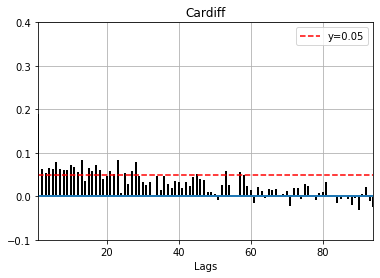

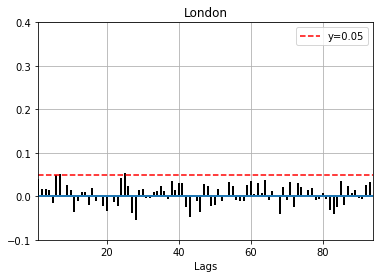

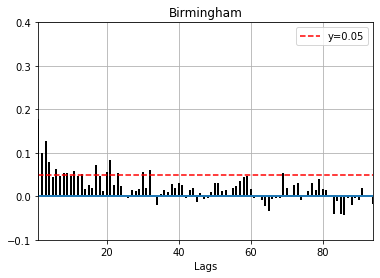

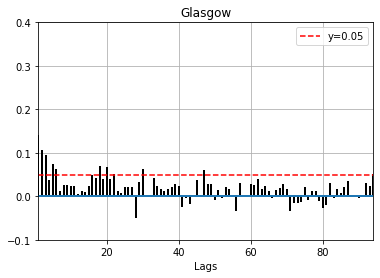

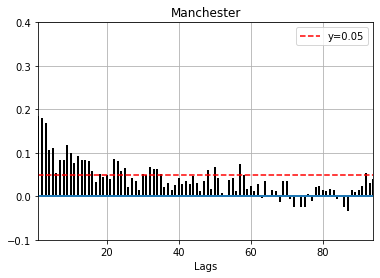

In [77]:
#auto-correlation for point predictions for center point of cities

cities = ["Cardiff","London","Birmingham","Glasgow","Manchester"]
for city in cities:
    temp = {"fp": f"./THST_mc_dropout_Normal_True__{city}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    print("\n")
    
    auto_correllation_plots( temp, city, errors=True )

In [270]:
#cross-correlation for predictions for center point of cities

main_city_name = "Leeds"
comparison_cities = ["Bradford","Manchester","Liverpool","Edinburgh","London","Cardiff"]

main_city = {"fp": f"./Output/THST_mc_dropout_Normal_True__{main_city_name}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   

pd_acfl1 = pd.DataFrame(columns=comparison_cities)

for city_name in comparison_cities:
    temp = {"fp": f"./Output/THST_mc_dropout_Normal_True__{city_name}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    print("\n")
    lag0_acf, lag0_acf_observed  = cross_correllation_plots( [main_city,temp], [main_city_name, city_name] )
    
    pd_acfl1[city_name] = [lag0_acf, lag0_acf_observed]
    
pd_acfl1.index.name ="Lag"
pd_acfl1 = pd_acfl1.set_index( pd.Index(['TRUNET-CC', 'Observed']) )
plot_lag0_xcorrs = pd_acfl1.transpose().plot.line()
plt.grid(True)
plt.xlabel('City')
plt.ylabel('Correlation co-eff')
plt.title(f'XCF with Leeds as base city')
plt.savefig(f"Output/Experiment1/figures/Xcorr_lag0_{main_city_name}.png")
plt.close()

# pd_acfl1.to_latex( buf=os.path.dirname(main_city['fp'])+"/x_corr_preds_table.tex",  float_format="{:0.3f}".format, caption=f"Lag 0 Cross Corellation for {main_city['model_name']} point predictions for {main_city_name} and {city_name}. \
#                         {main_city['model_name']} was trained on data \
#                            between 1979 and 2013 and tested on the relevant $7.1 {{\\times}} 10^3$ $\mathrm{{km}}^2$ regions between 2014 and 2019-07".replace("_","\-"))

In [ ]:
#auto-correlation for point prediction errors for center point of cities
cities = ["Cardiff","London","Birmingham","Glasgow","Manchester"]
for city in cities:
    temp = {"fp": f"./THST_mc_dropout_Normal_True__{city}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    print("\n")
    
    auto_correllation_plots( temp, city, errors=True )

In [166]:
#cross-correlation for predictions errors for center point of cities
main_city_name = "Leeds"
comparison_cities = ["Glasgow","Manchester","Liverpool","London","Cardiff"]

main_city = {"fp": f"./THST_mc_dropout_Normal_True__{main_city_name}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   

pd_acfl1 = pd.DataFrame(columns=comparison_cities)

for city_name in comparison_cities:
    temp = {"fp": f"./THST_mc_dropout_Normal_True__{city_name}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    print("\n")
    
    lag0_xcf = cross_correllation_plots( [main_city,temp], [main_city_name,city_name], errors=True )

    pd_acfl1[city_name] = [lag0_xcf]
        
pd_acfl1.index.name ="Lag"

pd_acfl1.to_latex( buf=os.path.dirname(main_city['fp'])+"/x_corr_error_table.tex",  float_format="{:0.3f}".format, caption=f"Lag 0 Cross Corellation for {main_city['model_name']} point predictions for {main_city_name} and {city_name}. \
                        {main_city['model_name']} was trained on data \
                           between 1979 and 2013 and tested on the relevant $7.1 {{\\times}} 10^3$ $\mathrm{{km}}^2$ regions between 2014 and 2019-07".replace("_","\-"))

# Single Model: Decade by Decade Evaluation

In [190]:
#decade by decade
cities = ["Cardiff","London","Birmingham","Glasgow","Manchester"]
for city in cities:
    temp = {"fp": f"./THST_mc_dropout_Normal_True__{city}_train1979_1995_1995_2000_test2000_2019-07-02/Predictions/_regional.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}    
    decade_by_decade_eval( temp, city )
    print("\n")

            RMSE   R10RMSE  Avg Abs Bias  Avg Pred   Avg Obs
Decade                                                      
2000s   1.806742  4.534537      0.965318   2.42169  2.858970
2010s   1.743586  4.109359      0.965924   2.37085  2.658513


            RMSE   R10RMSE  Avg Abs Bias  Avg Pred  Avg Obs
Decade                                                     
2000s   1.853735  5.461151      0.942699  2.098647  1.88435
2010s   1.751201  5.000668      0.934184  2.025523  1.71041


            RMSE   R10RMSE  Avg Abs Bias  Avg Pred   Avg Obs
Decade                                                      
2000s   1.716340  4.769386      0.911566  2.266874  2.047490
2010s   1.651417  4.399352      0.910807  2.162126  1.847739


            RMSE   R10RMSE  Avg Abs Bias  Avg Pred   Avg Obs
Decade                                                      
2000s   2.569699  6.307909      1.411301  3.180131  3.674204
2010s   2.694874  6.020890      1.559929  3.197420  4.020825


            RMSE   R

# Scatter Plots

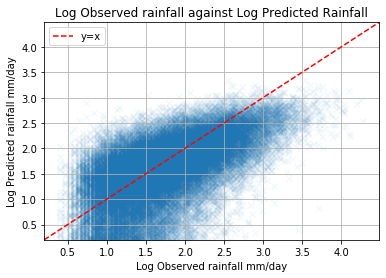

In [220]:
temp = {"fp": f"Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_All_train1979_2009_2014_test2014_2019-07-02_/Predictions/", 'distr_name':None, "model_name":"TNET-CC"}
scatter_plot(temp, threshold=0.5)